In [23]:
import serial
from serial.tools import list_ports
import json
import numpy as np
import time
from glob import glob   # To open files
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import chi2 # to obtain the p-value from the chi squared

# Size plots & labels
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [24]:
# Define function of a straight line for best-fit-line of calibration
def f(x,m,c):
    return m*x + c

# Define function to test goodness of fit
def chi_squared(measured, expected, measured_err, n_params):
    chi_sq = np.sum(((measured-expected) / measured_err)**2)
    dof = len(measured) - n_params
    p_val = chi2.sf(chi_sq, dof)
    return chi_sq/dof, p_val

def decay(t, A, tau, C):
    return A*np.exp(-t/tau) + C

# Calibration with Teensy 4.0 

## Data acquisition

In [2]:
# Check what COM port it is on
from serial.tools import list_ports
for p in list_ports.comports():
    print(p)

COM3 - USB Serial Device (COM3)
COM1 - Communications Port (COM1)


In [3]:
# Set up a connection
ser = serial.Serial(
    "com3",
    baudrate = 115200,
    timeout = 1  # seconds - timeout needed so that device is not blocked indefinetly if it has no data
)

In [4]:
# String to byte conversion
def data(mystring):
    return bytes(mystring+'\n','utf-8')

In [5]:
delays = np.arange(200, 10000, 200)   # from 0.2 to 10 μs in steps of 0.2

for delay in delays:
    js = json.dumps(dict(pulseWidth=20, interPulseDelay=float(delay), pulseInterval=10))   # delay is end-to-start difference
    
    ser.write(data(js))
    time.sleep(5)
    
#ser.readlines()

In [6]:
ser.close()

## Data analysis

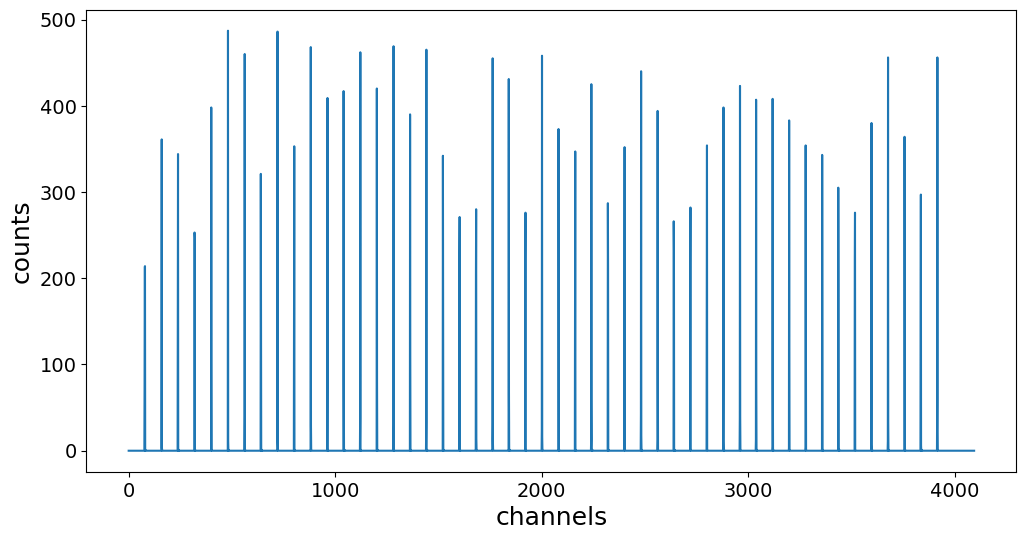

In [3]:
calibration_paths = glob("Calibration Files/*")
delays = np.arange(0.2, 10, 0.2)   # μs
calibration_data = []

for path in calibration_paths:
    data = np.loadtxt(path, unpack=True, delimiter=' ')

    if len(delays) == len(np.nonzero(data)[0]):
        peaks = np.nonzero(data)[0]
    else:   # If some pulses with the same delay went into the neighbouring channels...
        peaks = find_peaks(data, distance=35)[0]   #... get channels with the local maxima
    calibration_data.append(peaks)
    
    
plt.plot(np.loadtxt("Calibration Files/calibration_teensy.txt", unpack=True))
plt.xlabel('channels')
plt.ylabel('counts')
plt.show()

Best-fit line: 400.2709x + 1.1459
Uncertainties on: m = 0.0420, c = 0.1672


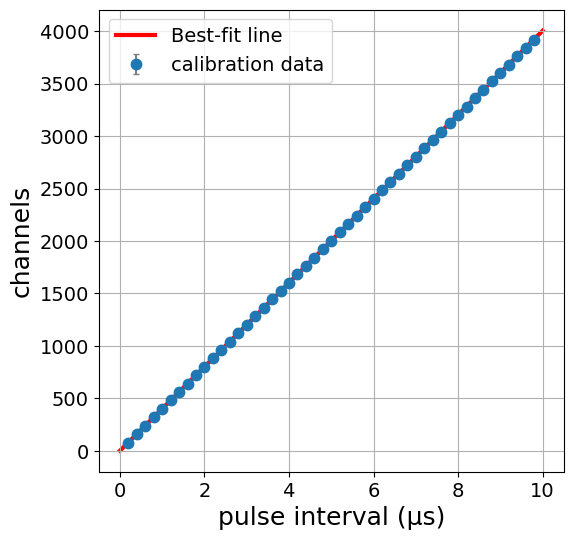

In [114]:
plt.figure(figsize=(6,6))

calibration_channels = np.mean(calibration_data, axis=0)
calibration_err = np.std(calibration_data, axis=0)
calibration_err[calibration_err < 0.5] = 0.5   # if 0, replace with half a channel - if 0, curve_fit would crash

popt, pcov = curve_fit(f, delays, calibration_channels, sigma=calibration_err, absolute_sigma=True)
m, c = popt
m_err, c_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {m:.4f}x + {c:.4f}")
print(f"Uncertainties on: m = {m_err:.4f}, c = {c_err:.4f}")

# Plot the line
xfit = np.linspace(0, 10, 500)
yfit = f(xfit, m, c)
plt.plot(xfit, yfit, 'r-', label="Best-fit line", linewidth=3, zorder=0)

plt.errorbar(delays, calibration_channels, yerr=calibration_err, marker='o', ms=7.5, capsize=2, ecolor='grey', ls='None', label='calibration data')
plt.xlabel('pulse interval (μs)')
plt.ylabel('channels')
plt.legend()
plt.grid()
plt.savefig('calibration_line.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Use the chi_squared function
chi_sq, p_val = chi_squared(calibration_channels, f(delays, m, c), calibration_err, len(popt))
print(f"Chi-squared = {chi_sq:.3g}, p-value = {p_val:.3g}")

Chi-squared = 4.84, p-value = 1.69e-25


In [50]:
# Use the chi_squared function
(m_, c_), _ = curve_fit(f, delays, calibration_channels, sigma=calibration_err*np.sqrt(chi_sq), absolute_sigma=True)
chi_sq, p_val = chi_squared(calibration_channels, f(delays, m_, c_), calibration_err*np.sqrt(chi_sq), len(popt))
print(f"Chi-squared = {chi_sq:.3g}, p-value = {p_val:.3g}")

Chi-squared = 1, p-value = 0.473


# Muon Detector

## Run 1 

In [6]:
# True, False means that the last 110 channels are 0s. The last 111th isn't
(np.loadtxt('Run1/Run1 (149).txt', unpack=True)[-110:] == 0).all(), (np.loadtxt('Run1/Run1 (149).txt', unpack=True)[-111:] == 0).all()

(True, False)

Best-fit line: 49.9441*exp(-t/2.1145) + 0.6873
Uncertainties on: A = 0.4477, tau = 0.0319, C = 0.1362


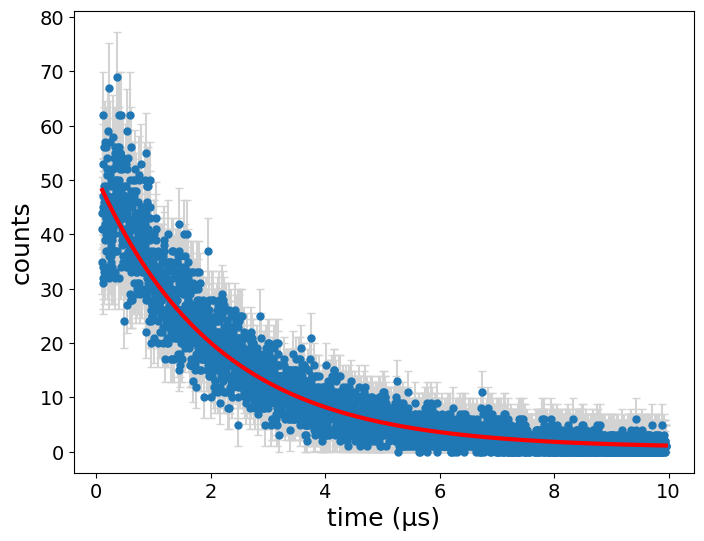

In [55]:
final_data = np.loadtxt('Run1/Run1 (149).txt', unpack=True)[44:-110]
yerr = np.sqrt(final_data)   # Poisson noise
# Channels with small or even 0 counts weight the fit wrongfully so set min err
floor = np.median(yerr[:np.argwhere(final_data==0)[0][0]])   # take median of errors of up until where first channel w/ 0 counts is found
yerr[yerr<floor] = floor

x = np.arange(44, len(final_data)+44)
x = (x-c)/m

p0 = [max(final_data), 2.2, min(final_data)]
popt, pcov = curve_fit(decay, x, final_data, sigma=yerr, p0=p0, absolute_sigma=True)
A, tau, C = popt
A_err, tau_err, C_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A:.4f}*exp(-t/{tau:.4f}) + {C:.4f}")
print(f"Uncertainties on: A = {A_err:.4f}, tau = {tau_err:.4f}, C = {C_err:.4f}")

plt.figure(figsize=(8,6))
lower_err = np.where(final_data - yerr < 0, final_data, yerr)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A,tau,C), 'r-', linewidth=3)
plt.errorbar(x, final_data, yerr=[lower_err,yerr], fmt='o', ms=5, zorder=0, capsize=3, ecolor='lightgray')
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.savefig('run1_full_decay.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# Use the chi_squared function
chi_sq, p_val = chi_squared(final_data, decay(x,A,tau,C), yerr, len(popt))
print(f"Chi-squared = {chi_sq:.2f}, p-value = {p_val:.3f}")

Chi-squared = 0.51, p-value = 1.000


In [57]:
paths = glob("Run1/*")
total_counts = [0.0]

for path in paths:
    data = np.loadtxt(path, unpack=True, delimiter=' ')
    total_counts.append(np.sum(data))
    
max(total_counts)

43999.0

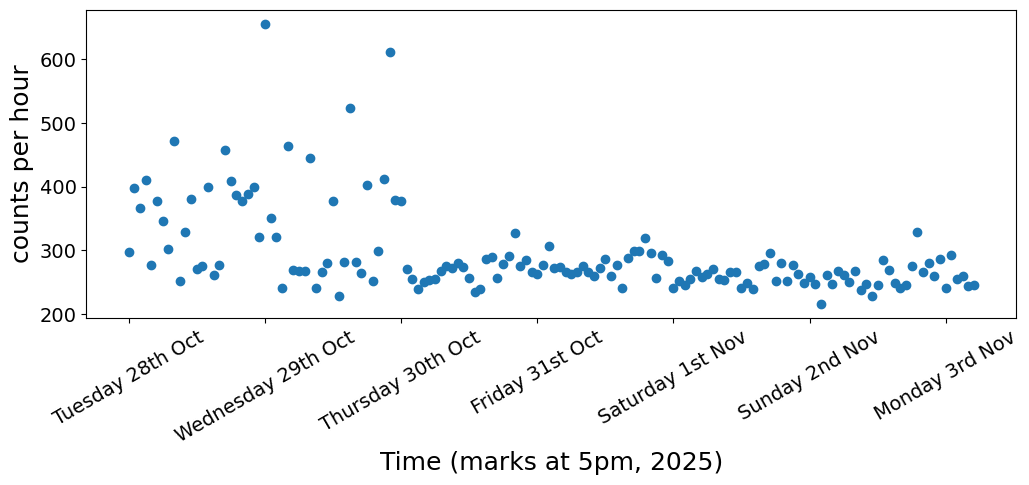

In [65]:
total_counts.sort()
count_rate = np.diff(total_counts)
if count_rate.any()<0: print("Error: counter may have been cleared/program may have crashed")

xticks, xlabels = np.arange(0,150,24), ['Tuesday 28th Oct', 'Wednesday 29th Oct', 'Thursday 30th Oct', 'Friday 31st Oct',
                                        'Saturday 1st Nov', 'Sunday 2nd Nov', 'Monday 3rd Nov']
plt.figure(figsize=(12,4))
plt.plot(count_rate, 'o')
plt.xticks(xticks, xlabels, rotation=30)
plt.xlabel('Time (marks at 5pm, 2025)')
plt.ylabel('counts per hour')
#plt.grid()
plt.savefig('countrate_run1_full', dpi=300, bbox_inches='tight')
plt.show()

It seems like something else was triggering the scintillator in the first 48 hours

Best-fit line: 17.8129*exp(-t/2.2108) + 0.3270
Uncertainties on: A = 0.2824, tau = 0.0739, C = 0.1229


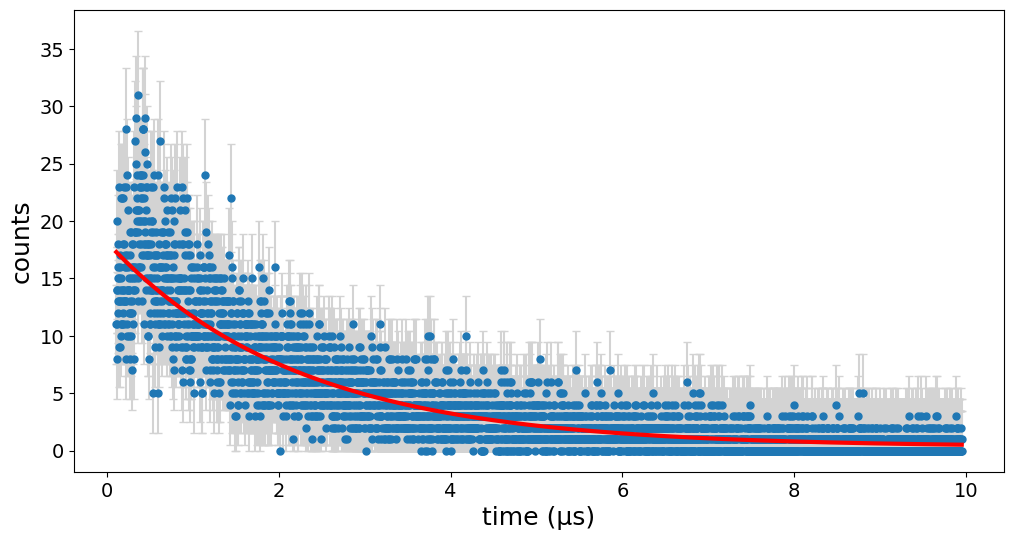

In [76]:
# Find which is the last file where another source triggered the scintillator (files were not chronological)
for i, path in enumerate(paths):
    data = np.loadtxt(path, unpack=True, delimiter=' ')
    if np.sum(data) == total_counts[48]:
        section1 = data[44:-110]
        break

yerr1 = np.sqrt(section1)   # Poisson noise
floor = np.median(yerr1[:np.argwhere(section1==0)[0][0]])
yerr1[yerr1<floor] = floor

popt, pcov = curve_fit(decay, x, section1, sigma=yerr1, absolute_sigma=True)
A1, tau1, C1 = popt
A1_err, tau1_err, C1_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A1:.4f}*exp(-t/{tau1:.4f}) + {C1:.4f}")
print(f"Uncertainties on: A = {A1_err:.4f}, tau = {tau1_err:.4f}, C = {C1_err:.4f}")

lower_err1 = np.where(section1 - yerr1 < 0, section1, yerr1)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A1,tau1,C1), 'r-', linewidth=3)
plt.errorbar(x, section1, yerr=[lower_err1,yerr1], fmt='o', ms=5, capsize=3, ecolor='lightgray', zorder=0)
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

High background counts `C` which proabaly means there was a lot of background radiation making the apparent mean lifetime higher than it actually is.

Best-fit line: 31.4331*exp(-t/2.2088) + 0.0983
Uncertainties on: A = 0.3581, tau = 0.0502, C = 0.1435


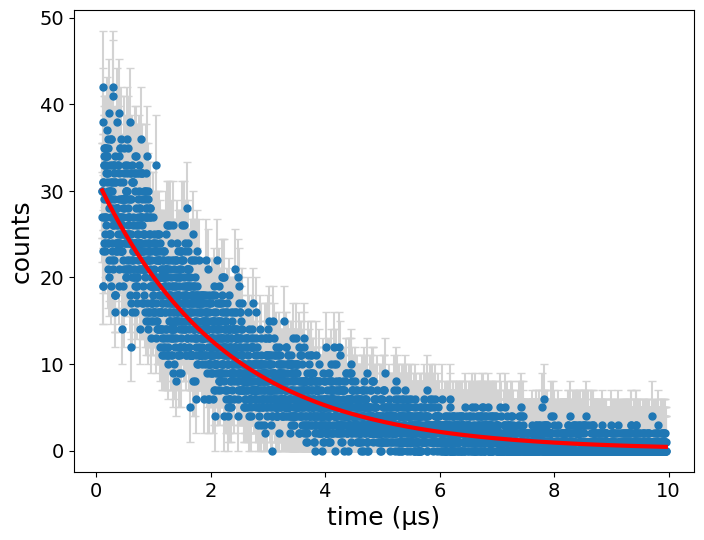

In [86]:
section2 = final_data-section1
yerr2 = np.sqrt(section2)   # Poisson noise
floor = np.median(yerr2[:np.argwhere(section2==0)[0][0]])   # Channels with small or even 0 counts weight the fit wrongfully so set min err
yerr2[yerr2<floor] = floor

popt, pcov = curve_fit(decay, x, section2, sigma=yerr2, absolute_sigma=True)
A2, tau2, C2 = popt
A2_err, tau2_err, C2_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A2:.4f}*exp(-t/{tau2:.4f}) + {C2:.4f}")
print(f"Uncertainties on: A = {A2_err:.4f}, tau = {tau2_err:.4f}, C = {C2_err:.4f}")

plt.figure(figsize=(8,6))
lower_err2 = np.where(section2 - yerr2 < 0, section2, yerr2)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A2,tau2,C2), 'r-', linewidth=3)
plt.errorbar(x, section2, yerr=[lower_err2,yerr2], fmt='o', ms=5, capsize=3, ecolor='lightgray', zorder=0)
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.savefig('run1_section2_decay.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
# Use the chi_squared function
chi_sq, p_val = chi_squared(section2, decay(x,A2,tau2,C2), yerr2, len(popt))
print(f"Chi-squared = {chi_sq:.2f}, p-value = {p_val:.3f}")

Chi-squared = 0.36, p-value = 1.000


Proof that high floor is needed - poor fit (p-value is >$10^{-3}$):

Chi-squared = 1.16, p-value = 0.000


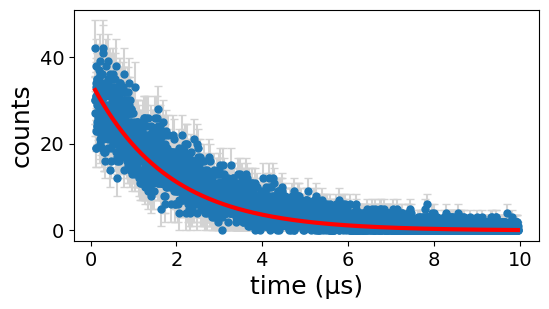

In [79]:
yerr2_ = np.sqrt(section2)
yerr2_[yerr2_<0.5] = 0.5

popt, pcov = curve_fit(decay, x, section2, sigma=yerr2_, absolute_sigma=True)
A2_, tau2_, C2_ = popt

chi_sq_, p_val_ = chi_squared(section2, decay(x,A2_,tau2_,C2_), yerr2_, len(popt))
print(f"Chi-squared = {chi_sq_:.2f}, p-value = {p_val_:.3f}")

plt.figure(figsize=(6,3))
plt.plot(x, decay(x,A2_,tau2_,C2_), 'r-', linewidth=3)
plt.errorbar(x, section2, yerr=[lower_err2,yerr2_], fmt='o', ms=5, capsize=3, ecolor='lightgray', zorder=0)
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

Now, this result (section2, proper floor) seems better. $\tau$ is closer to the accepted value and there are lesser background conuts. Let's look at the standard deviation from the mean for this section 2 to see if it seems right

Data points within 1σ: 70.3%
Data points within 2σ: 95.0%


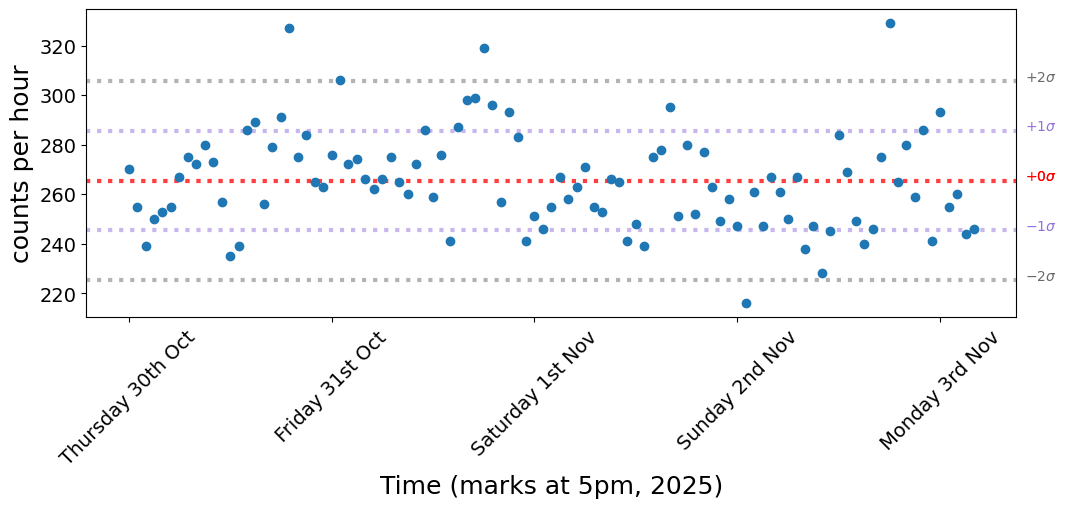

In [85]:
plt.figure(figsize=(12,4))

count_rate2 = count_rate[49:]
xticks2, xlabels2 = np.arange(0,102,24), ['Thursday 30th Oct', 'Friday 31st Oct',
                                        'Saturday 1st Nov', 'Sunday 2nd Nov', 'Monday 3rd Nov']

mean, std = np.mean(count_rate2), np.std(count_rate2)

for n, color in enumerate(['r', 'mediumpurple', 'dimgray']):
    plt.axhline(mean + n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.axhline(mean - n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.text(len(count_rate2) + 5, mean + n*std, f'$+{n}\\sigma$', color=color)
    plt.text(len(count_rate2) + 5, mean - n*std, f'$-{n}\\sigma$', color=color)

within_1sigma = np.mean((count_rate2 >= mean - std) & (count_rate2 <= mean + std))
within_2sigma = np.mean((count_rate2 >= mean - 2*std) & (count_rate2 <= mean + 2*std))
print(f"Data points within 1σ: {within_1sigma*100:.1f}%")
print(f"Data points within 2σ: {within_2sigma*100:.1f}%")

plt.plot(count_rate2, 'o')
plt.xticks(xticks2, xlabels2, rotation=45)
plt.xlabel('Time (marks at 5pm, 2025)')
plt.ylabel('counts per hour')
#plt.grid()
plt.savefig('countrate_run1_section2.jpg', dpi=300, bbox_inches='tight')
plt.show()

All in order... but what was causing those extra counts in the first 48 hours?

Best-fit line: 0.0769*exp(-t/1.7906) + 0.0070
Uncertainties on: A = 0.0043, tau = 0.1898, C = 0.0014


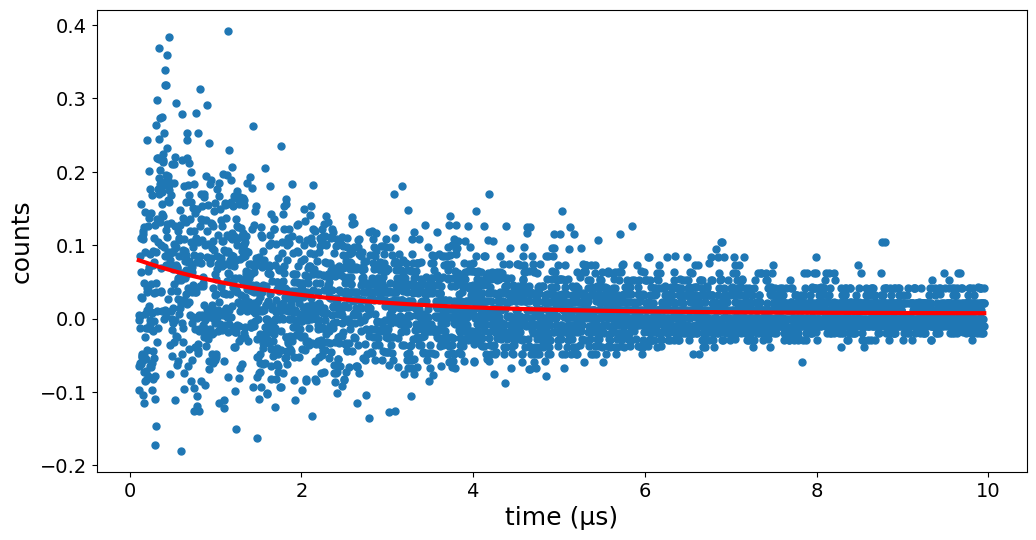

In [30]:
section1_normalized = section1 / 48
section2_normalized = section2 / 102

popt, pcov = curve_fit(decay, x, (section1_normalized - section2_normalized))
A3, tau3, C3 = popt
A3_err, tau3_err, C3_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A3:.4f}*exp(-t/{tau3:.4f}) + {C3:.4f}")
print(f"Uncertainties on: A = {A3_err:.4f}, tau = {tau3_err:.4f}, C = {C3_err:.4f}")

plt.plot(x, decay(x,A3,tau3,C3), 'r-', linewidth=3)
plt.plot(x, (section1_normalized - section2_normalized), 'o', ms=5, zorder=0)
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

Doesn't seem like another constant source of radiation with a specific meanlife does it? Let's check if there is any pattern in the hours at all

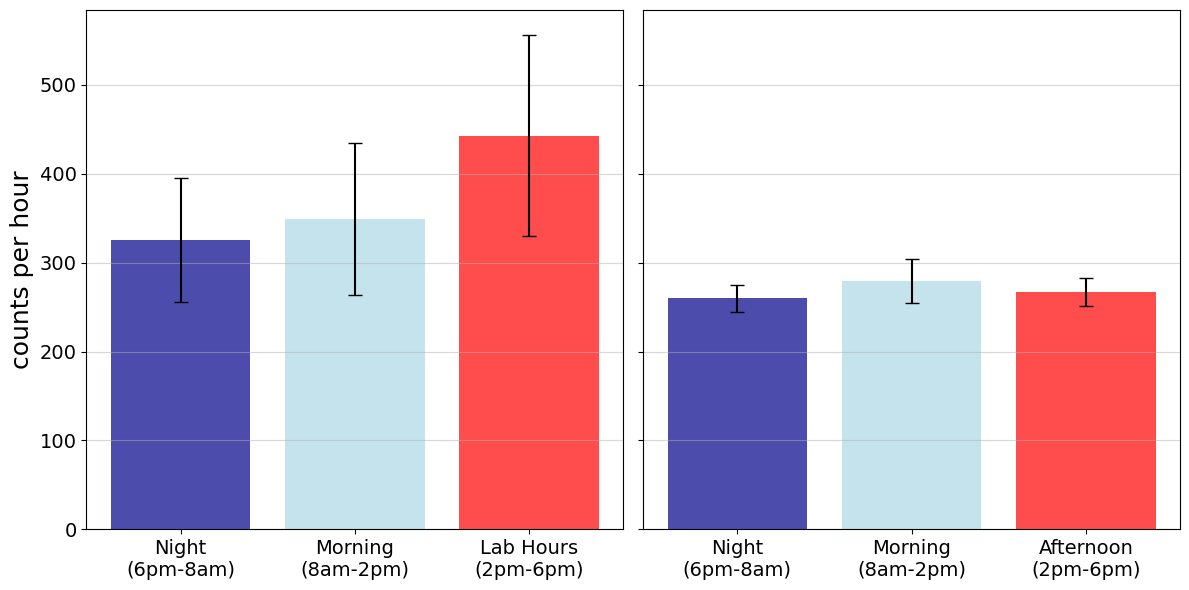

In [68]:
pre_night = np.concatenate([count_rate[0:15], count_rate[25:39]])
pre_morning = np.concatenate([count_rate[15:21], count_rate[39:45]])
pre_lab = np.concatenate([count_rate[21:25], count_rate[45:49]])

post_night = np.concatenate([count_rate[49:63], count_rate[73:87], count_rate[97:111], count_rate[121:135]])
post_morning = np.concatenate([count_rate[63:69], count_rate[87:93], count_rate[111:117], count_rate[135:141]])
post_afternoon = np.concatenate([count_rate[69:73], count_rate[93:97], count_rate[117:121], count_rate[141:145]])

fig, ax = plt.subplots(1, 2, sharey=True)

# FIRST 48 HOURS
y_period = [np.mean(period) for period in [pre_night, pre_morning, pre_lab]]
y_period_err = [np.std(period) for period in [pre_night, pre_morning, pre_lab]]
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(['Night\n(6pm-8am)', 'Morning\n(8am-2pm)', 'Lab Hours\n(2pm-6pm)'])
ax[0].set_ylabel('counts per hour')
ax[0].grid(axis='y', alpha=0.5)
ax[0].bar([1,2,3], y_period, yerr=y_period_err, capsize=5, alpha=0.7,
         color=['darkblue', 'lightblue', 'r'])

# REST OF THE HOURS
y_period = [np.mean(period) for period in [post_night, post_morning, post_afternoon]]
y_period_err = [np.std(period) for period in [post_night, post_morning, post_afternoon]]
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(['Night\n(6pm-8am)', 'Morning\n(8am-2pm)', 'Afternoon\n(2pm-6pm)'])
ax[1].grid(axis='y', alpha=0.5)
ax[1].bar([1,2,3], y_period, yerr=y_period_err, capsize=5, alpha=0.7,
         color=['darkblue', 'lightblue', 'r'])

plt.tight_layout()
plt.savefig('pre_vs_post_run1_hist.jpg', dpi=300, bbox_inches='tight')
plt.show()

It can be seen again that the first section has more fluctuations in counts (bigger errorbars) than the second one. This is not due to a big difference between the first 24h period and the sceond one (see below, both have large errors).

Other than that, it can be seen that in the first section, there is an overall counts offset most probalby due to backgrund radiation. The relationship between night and morning is conserved with the night having just slightly lower counts than the morning. However, the big difference for the 2-6 pm period in section 1 with respect to the morning and night counts suggests that most of those fluctuations within the first 48 hours where indeed from some activity within the undergraduate labs. Notice how as soon as the labs close on Thursday at 6pm, the counts per hour stabilize.

But if it was just to activity within the labs, it would only affect the 2-6 pm region. However, There is indeed a constant offset for the morning and night periods for the first 48 hours. A hypothesis for what could have caused all this is the radioactive calibration sources located behind the scintillator being brought in and out during lab hours and the metallic box they are saved in, not being properly closed between Tuesday, Wednesday and Thursday's lab sessions but being closed properly at the end of Thursday's session.

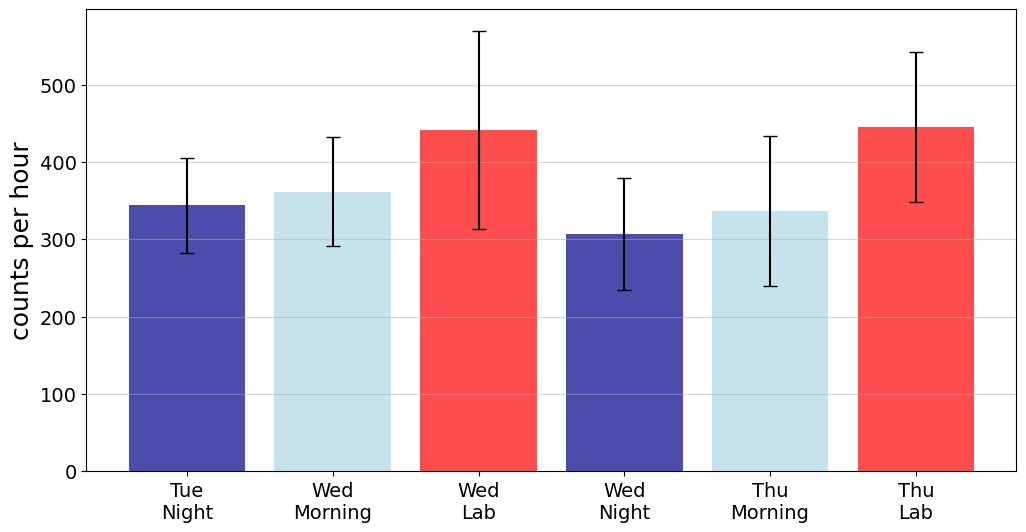

In [70]:
tue_night, wed_morning, wed_lab = count_rate[0:15], count_rate[15:21], count_rate[21:25]
wed_night, thu_morning, thu_lab = count_rate[25:39], count_rate[39:45], count_rate[45:49]

periods = [tue_night, wed_morning, wed_lab, wed_night, thu_morning, thu_lab]
y_48h = [period.mean() for period in periods]
y_48h_err = [period.std() for period in periods]

plt.bar(np.arange(6), y_48h, yerr=y_48h_err, capsize=5, alpha=0.7, 
        color=['darkblue', 'lightblue', 'red', 'darkblue', 'lightblue', 'red'])
plt.xticks(np.arange(6), ['Tue\nNight', 'Wed\nMorning', 'Wed\nLab', 'Wed\nNight', 'Thu\nMorning', 'Thu\nLab'])
plt.ylabel('counts per hour')
plt.grid(axis='y', alpha=0.5)
plt.savefig('wed_vs_thu_run1_hist.jpg', dpi=300, bbox_inches='tight')

Below is a more detailed view of the features highlited earlier with the fluctuation on the first 48 hours and the clear evolution throughout the day after the first 48 hours with the counts increasing during the morning starting at 8 am and peaking around noon

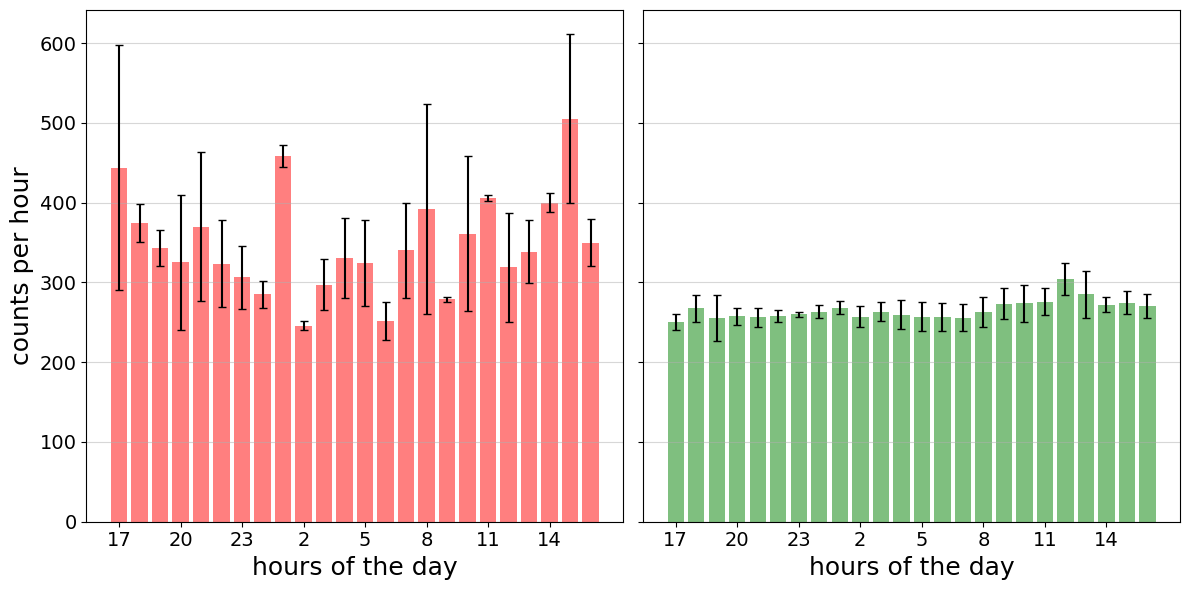

In [71]:
hours = np.arange(len(count_rate)) % 24

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# FIRST 48 HOURS
y_hours = [np.mean(count_rate[:49][hours[:49]==h]) for h in range(24)]   # For every measurement in hours[:49], check if it is the same as h, 0-23
y_hours_err = [np.std(count_rate[:49][hours[:49]==h]) for h in range(24)]
ax[0].bar(range(24), y_hours, yerr=y_hours_err, capsize=3, color='r', alpha=0.5)
ax[0].grid(axis='y', alpha=0.5)
ax[0].set_xticks(np.arange(0,24,3))
ax[0].set_xticklabels([(17+h)%24 for h in np.arange(0,24,3)])
ax[0].set_ylabel('counts per hour')
ax[0].set_xlabel('hours of the day')

# REST OF THE HOURS
y_hours = [np.mean(count_rate[49:][hours[49:]==h]) for h in range(24)]   # For every measurement in hours[:49], check if it is the same as h, 0-23
y_hours_err = [np.std(count_rate[49:][hours[49:]==h]) for h in range(24)]
ax[1].bar(range(24), y_hours, yerr=y_hours_err, capsize=3, color='g', alpha=0.5)
ax[1].grid(axis='y', alpha=0.5)
ax[1].set_xticks(np.arange(0,24,3))
ax[1].set_xticklabels([(17+h)%24 for h in np.arange(0,24,3)])
ax[1].set_xlabel('hours of the day')

plt.tight_layout()
plt.savefig('hourly_run1_hist.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Run 2

In [88]:
# Run 2 was cleared after every measurement (10 minutes)
paths = glob("Run2/*")
count_rate = []
final_data = np.zeros(4096-44-110)

for path in paths:
    data = np.loadtxt(path, unpack=True, delimiter=' ')
    count_rate.append(np.sum(data))
    final_data += data[44:-110]

count_rate = np.array(count_rate)
np.sum(final_data)

12207.0

Best-fit line: 11.4591*exp(-t/2.7524) + -0.0053
Uncertainties on: A = 0.2040, tau = 0.1268, C = 0.1323


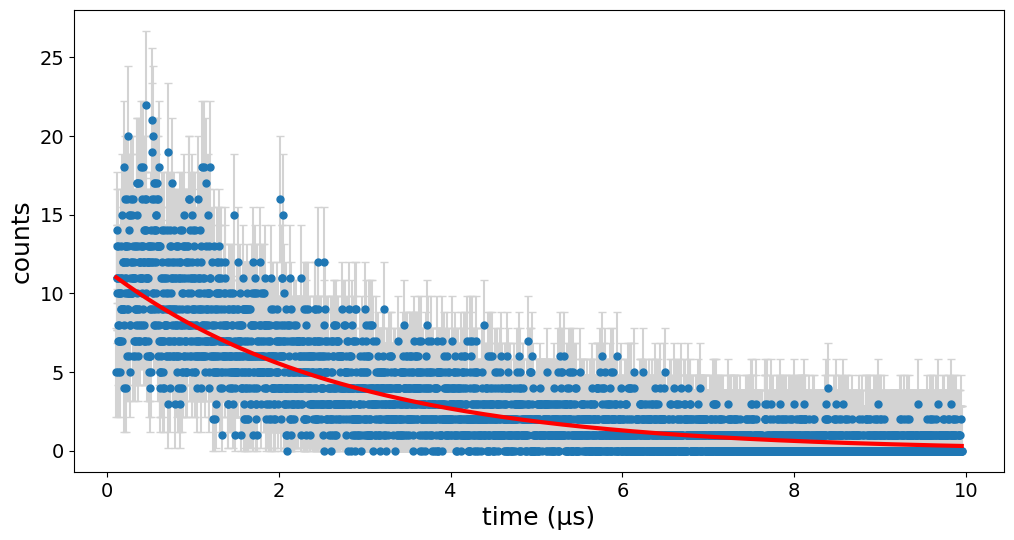

In [89]:
yerr = np.sqrt(final_data)   # Poisson noise
# Channels with small or even 0 counts weight the fit wrongfully so set min err
floor = np.median(yerr[:np.argwhere(final_data==0)[0][0]])   # take median of errors of up until where first channel w/ 0 counts is found
yerr[yerr<floor] = floor

x = np.arange(44, len(final_data)+44)
x = (x-c)/m

p0 = [max(final_data), 2.2, min(final_data)]
popt, pcov = curve_fit(decay, x, final_data, sigma=yerr, p0=p0, absolute_sigma=True)
A, tau, C = popt
A_err, tau_err, C_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A:.4f}*exp(-t/{tau:.4f}) + {C:.4f}")
print(f"Uncertainties on: A = {A_err:.4f}, tau = {tau_err:.4f}, C = {C_err:.4f}")

lower_err = np.where(final_data - yerr < 0, final_data, yerr)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A,tau,C), 'r-', linewidth=3)
plt.errorbar(x, final_data, yerr=[lower_err,yerr], fmt='o', ms=5, zorder=0, capsize=3, ecolor='lightgray')
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

Data points within 1σ: 75.7%
Data points within 2σ: 95.8%


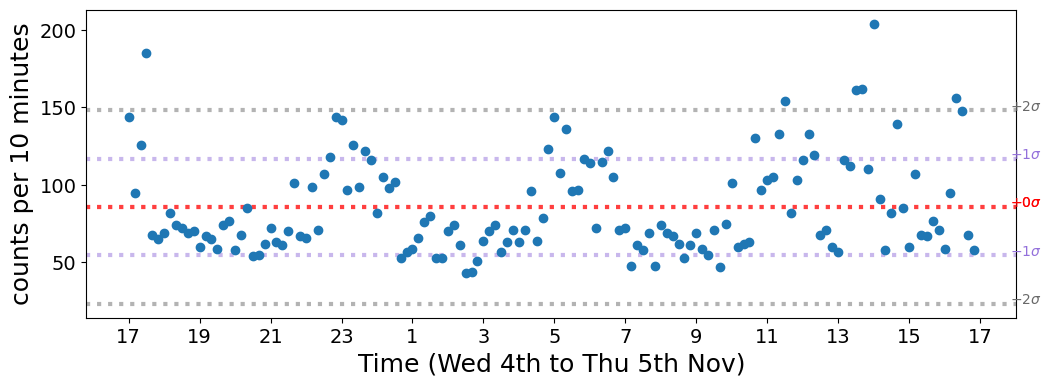

In [90]:
plt.figure(figsize=(12,4))

xticks = np.arange(0,len(count_rate)+1,12)   # tick every 12 points (each point is 10 minutes so 2h)
xlabels = (17 + xticks//6) % 24

mean, std = np.mean(count_rate), np.std(count_rate)

for n, color in enumerate(['r', 'mediumpurple', 'dimgray']):
    plt.axhline(mean + n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.axhline(mean - n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.text(len(count_rate) + 5, mean + n*std, f'$+{n}\\sigma$', color=color)
    plt.text(len(count_rate) + 5, mean - n*std, f'$-{n}\\sigma$', color=color)

within_1sigma = np.mean((count_rate >= mean - std) & (count_rate <= mean + std))
within_2sigma = np.mean((count_rate >= mean - 2*std) & (count_rate <= mean + 2*std))
print(f"Data points within 1σ: {within_1sigma*100:.1f}%")
print(f"Data points within 2σ: {within_2sigma*100:.1f}%")

plt.plot(count_rate, 'o')
plt.xticks(xticks, xlabels)
plt.xlabel('Time (Wed 4th to Thu 5th Nov)')
plt.ylabel('counts per 10 minutes')
#plt.grid()
plt.savefig('countrate_run2.jpg', dpi=300, bbox_inches='tight')
plt.show()

It can be see how in the first few runs and towards the end, there are higher number of counts

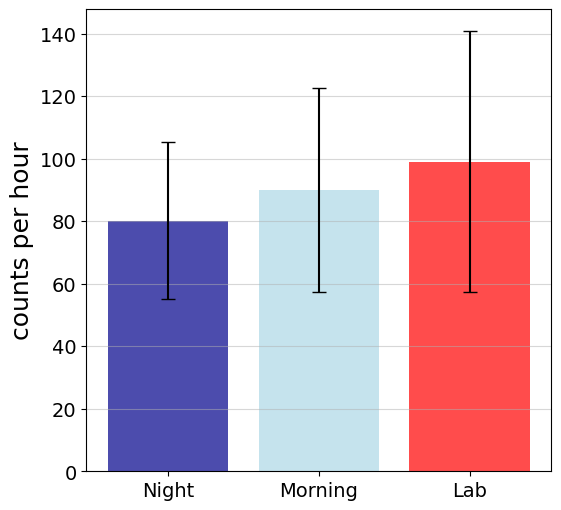

In [94]:
periods = [count_rate[6:90], count_rate[90:126], np.concatenate([count_rate[126:], count_rate[:6]])]   # night, morning, lab

y_run2 = [period.mean() for period in periods]
y_run2_err = [period.std() for period in periods]

plt.figure(figsize=(6,6))
plt.bar(np.arange(3), y_run2, yerr=y_run2_err, capsize=5, alpha=0.7, 
        color=['darkblue', 'lightblue', 'red'])
plt.xticks(np.arange(3), ['Night', 'Morning', 'Lab'])
plt.ylabel('counts per hour')
plt.grid(axis='y', alpha=0.5)
plt.savefig('periods_run2_hist.jpg', dpi=300, bbox_inches='tight')

Errors are big due to low threshold. However, afternoon/lab hours having higher counts than both morning and night just like in the first 48 hours of run hour support the hypothesis of the scintillator detecting more noise during lab hours.

Let's check if by, again, ignoring the lab hours, a better result is obtained

In [95]:
# Run 2 was cleared after every measurement (10 minutes)
paths = glob("Run2/*")
count_rate_nolab = []
final_data_nolab = np.zeros(4096-44-110)

for i, path in enumerate(paths):
    if i>=6 and i<126:
        data = np.loadtxt(path, unpack=True, delimiter=' ')
        count_rate_nolab.append(np.sum(data))
        final_data_nolab += data[44:-110]

count_rate_nolab = np.array(count_rate_nolab)
np.sum(final_data_nolab)

9839.0

Best-fit line: 9.5560*exp(-t/2.6982) + -0.0173
Uncertainties on: A = 0.1980, tau = 0.1451, C = 0.1280


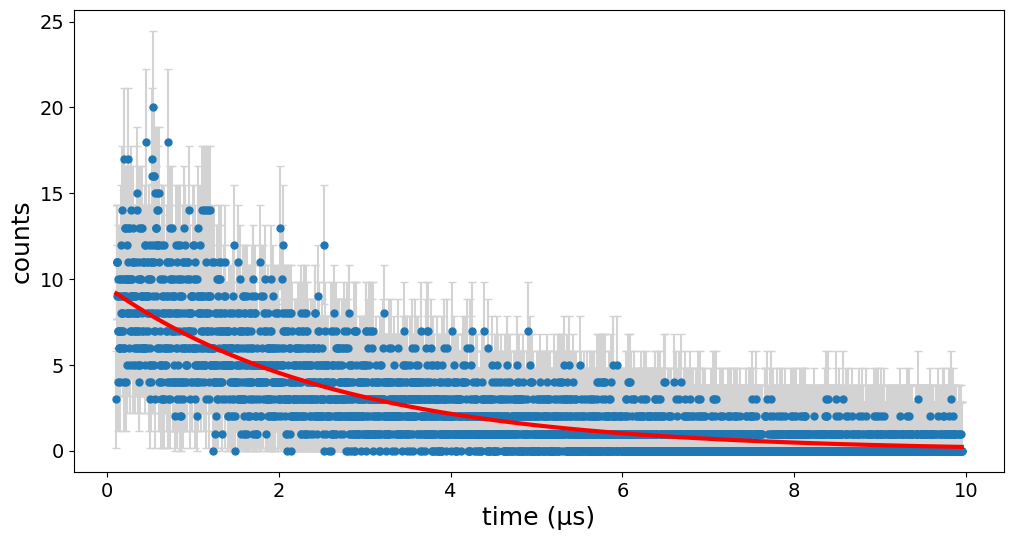

In [96]:
yerr = np.sqrt(final_data_nolab)   # Poisson noise
# Channels with small or even 0 counts weight the fit wrongfully so set min err
floor = np.median(yerr[:np.argwhere(final_data_nolab==0)[0][0]])   # take median of errors of up until where first channel w/ 0 counts is found
yerr[yerr<floor] = floor

x = np.arange(44, len(final_data_nolab)+44)
x = (x-c)/m

p0 = [max(final_data_nolab), 2.2, min(final_data_nolab)]
popt, pcov = curve_fit(decay, x, final_data_nolab, sigma=yerr, p0=p0, absolute_sigma=True)
A, tau, C = popt
A_err, tau_err, C_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A:.4f}*exp(-t/{tau:.4f}) + {C:.4f}")
print(f"Uncertainties on: A = {A_err:.4f}, tau = {tau_err:.4f}, C = {C_err:.4f}")

lower_err = np.where(final_data_nolab - yerr < 0, final_data_nolab, yerr)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A,tau,C), 'r-', linewidth=3)
plt.errorbar(x, final_data_nolab, yerr=[lower_err,yerr], fmt='o', ms=5, zorder=0, capsize=3, ecolor='lightgray')
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

It does improve a bit from 2.752 to 2.698. It is still not great probably because of the lower threshold.

## Run 3

In [105]:
# True, False means that the last 109 channels are 0s. The last 110th isn't
(np.loadtxt('Run3/Run3_150.txt', unpack=True)[-109:] == 0).all(), (np.loadtxt('Run3/Run3_150.txt', unpack=True)[-110:] == 0).all()

(True, False)

Best-fit line: 53.3619*exp(-t/2.2377) + 0.5832
Uncertainties on: A = 0.4465, tau = 0.0326, C = 0.1463


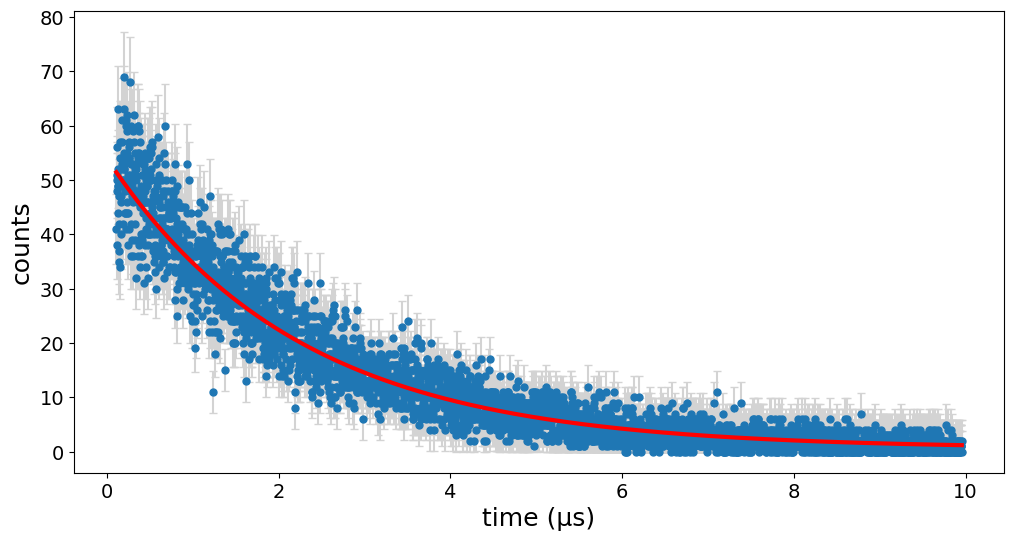

In [106]:
final_data = np.loadtxt('Run3/Run3_150.txt', unpack=True)[44:-109]
yerr = np.sqrt(final_data)   # Poisson noise
# Channels with small or even 0 counts weight the fit wrongfully so set min err
floor = np.median(yerr[:np.argwhere(final_data==0)[0][0]])   # take median of errors of up until where first channel w/ 0 counts is found
yerr[yerr<floor] = floor

x = np.arange(44, len(final_data)+44)
x = (x-c)/m

p0 = [max(final_data), 2.2, min(final_data)]
popt, pcov = curve_fit(decay, x, final_data, sigma=yerr, p0=p0, absolute_sigma=True)
A, tau, C = popt
A_err, tau_err, C_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A:.4f}*exp(-t/{tau:.4f}) + {C:.4f}")
print(f"Uncertainties on: A = {A_err:.4f}, tau = {tau_err:.4f}, C = {C_err:.4f}")

lower_err = np.where(final_data - yerr < 0, final_data, yerr)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A,tau,C), 'r-', linewidth=3)
plt.errorbar(x, final_data, yerr=[lower_err,yerr], fmt='o', ms=5, zorder=0, capsize=3, ecolor='lightgray')
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.show()

In [107]:
# Use the chi_squared function
chi_sq, p_val = chi_squared(final_data, decay(x,A,tau,C), yerr, len(popt))
print(f"Chi-squared = {chi_sq:.2f}, p-value = {p_val:.3f}")

Chi-squared = 0.51, p-value = 1.000


In [108]:
paths = glob("Run3/*")
total_counts = [0.0]

for path in paths:
    data = np.loadtxt(path, unpack=True, delimiter=' ')
    total_counts.append(np.sum(data))
    
max(total_counts)

48636.0

Data points within 1σ: 76.7%
Data points within 2σ: 96.0%


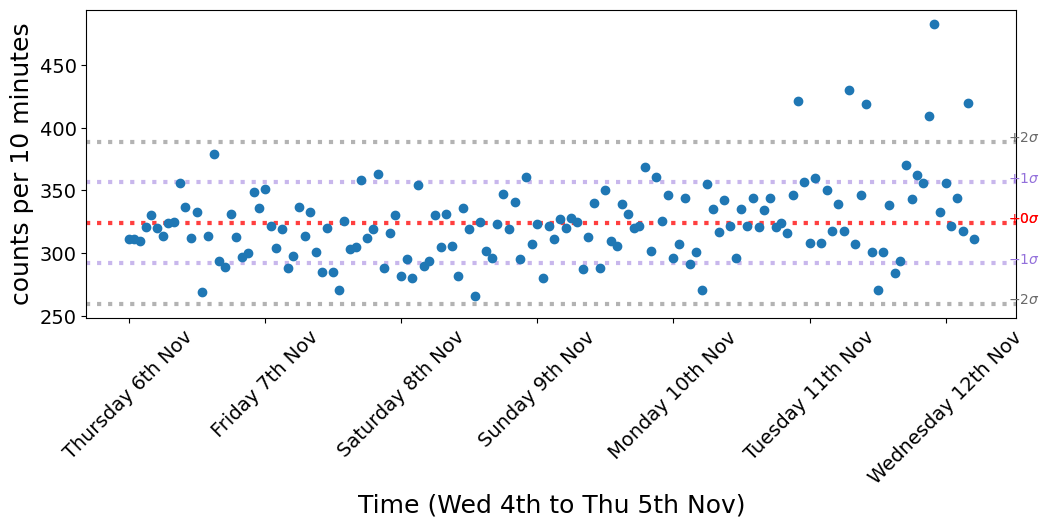

In [109]:
plt.figure(figsize=(12,4))

total_counts.sort()
count_rate = np.diff(total_counts)
if count_rate.any()<0: print("Error: counter may have been cleared/program may have crashed")

xticks, xlabels = np.arange(0,150,24), ['Thursday 6th Nov', 'Friday 7th Nov', 'Saturday 8th Nov', 'Sunday 9th Nov',
                                        'Monday 10th Nov', 'Tuesday 11th Nov', 'Wednesday 12th Nov']

mean, std = np.mean(count_rate), np.std(count_rate)

for n, color in enumerate(['r', 'mediumpurple', 'dimgray']):
    plt.axhline(mean + n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.axhline(mean - n*std, color=color, linestyle=':', linewidth=3, alpha=0.5)
    plt.text(len(count_rate) + 5, mean + n*std, f'$+{n}\\sigma$', color=color)
    plt.text(len(count_rate) + 5, mean - n*std, f'$-{n}\\sigma$', color=color)

within_1sigma = np.mean((count_rate >= mean - std) & (count_rate <= mean + std))
within_2sigma = np.mean((count_rate >= mean - 2*std) & (count_rate <= mean + 2*std))
print(f"Data points within 1σ: {within_1sigma*100:.1f}%")
print(f"Data points within 2σ: {within_2sigma*100:.1f}%")

plt.plot(count_rate, 'o')
plt.xticks(xticks, xlabels, rotation=45)
plt.xlabel('Time (Wed 4th to Thu 5th Nov)')
plt.ylabel('counts per 10 minutes')
#plt.grid()
plt.savefig('countrate_run3.jpg', dpi=300, bbox_inches='tight')
plt.show()

This shows just again a similar trend where days with open lab hours tend to have a higher count. Let's see if it is actually only lab hours or randoomly throughout the day

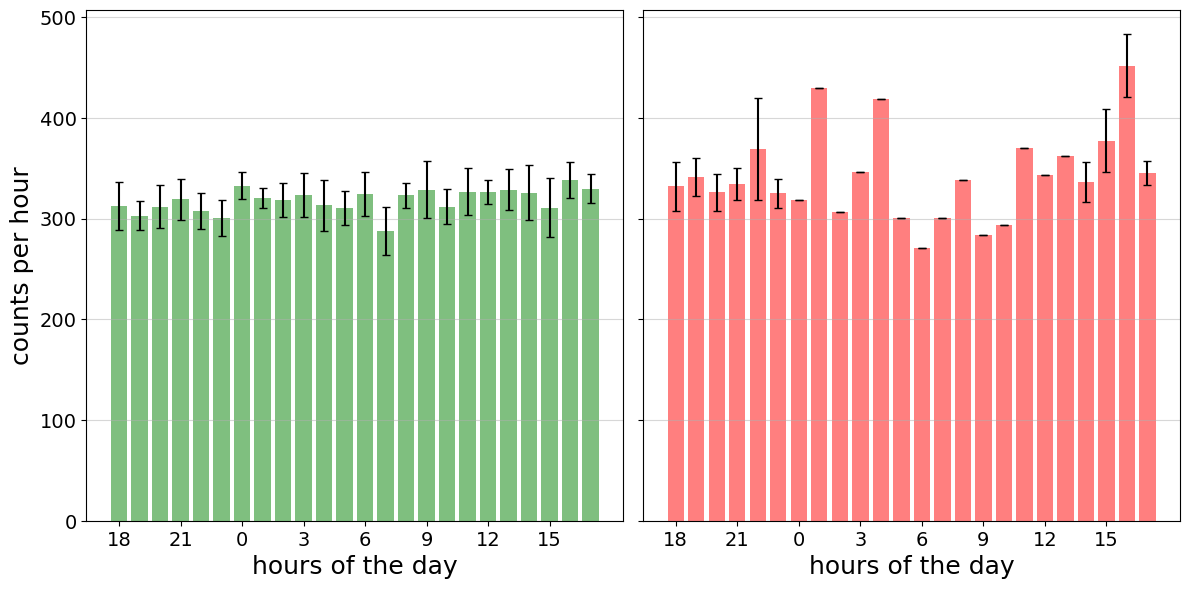

In [110]:
hours = np.arange(len(count_rate)) % 24

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# LAST 34 HOURS (since labs open until end)
y_hours = [np.mean(count_rate[-34:][hours[-34:]==h]) for h in range(24)]   # For every measurement in hours[:-48], check if it is the same as h, 0-23
y_hours_err = [np.std(count_rate[-34:][hours[-34:]==h]) for h in range(24)]
ax[1].bar(range(24), y_hours, yerr=y_hours_err, capsize=3, color='r', alpha=0.5)
ax[1].grid(axis='y', alpha=0.5)
ax[1].set_xticks(np.arange(0,24,3))
ax[1].set_xticklabels([(18+h)%24 for h in np.arange(0,24,3)])
ax[1].set_xlabel('hours of the day')

# REST OF THE HOURS
y_hours = [np.mean(count_rate[:-34][hours[:-34]==h]) for h in range(24)]   # For every measurement in hours[:49], check if it is the same as h, 0-23
y_hours_err = [np.std(count_rate[:-34][hours[:-34]==h]) for h in range(24)]
ax[0].bar(range(24), y_hours, yerr=y_hours_err, capsize=3, color='g', alpha=0.5)
ax[0].grid(axis='y', alpha=0.5)
ax[0].set_xticks(np.arange(0,24,3))
ax[0].set_xticklabels([(18+h)%24 for h in np.arange(0,24,3)])
ax[0].set_ylabel('counts per hour')
ax[0].set_xlabel('hours of the day')

plt.tight_layout()
plt.show()

It does seem like the first 5 days (although a bit more chaotic than the no-lab days from Run 1 - maybe because of the lower threshold) were more stable than the last 34 hours. Errors on the last 30 hours are 0 for big part because at those hours, measurements were only recorded for 1 day where lab hours

In [111]:
pre_night = np.concatenate([count_rate[0:14], count_rate[24:38], count_rate[48:62], count_rate[72:86], count_rate[96:110]])
pre_morning = np.concatenate([count_rate[14:20], count_rate[38:44], count_rate[62:68], count_rate[86:92], count_rate[110:116]])
pre_afternoon = np.concatenate([count_rate[20:24], count_rate[44:48], count_rate[68:72], count_rate[92:96]])

post_night = np.concatenate([count_rate[120:134], count_rate[144:]])
post_morning = np.concatenate([count_rate[134:140]])
post_lab = np.concatenate([count_rate[116:120], count_rate[140:144]])

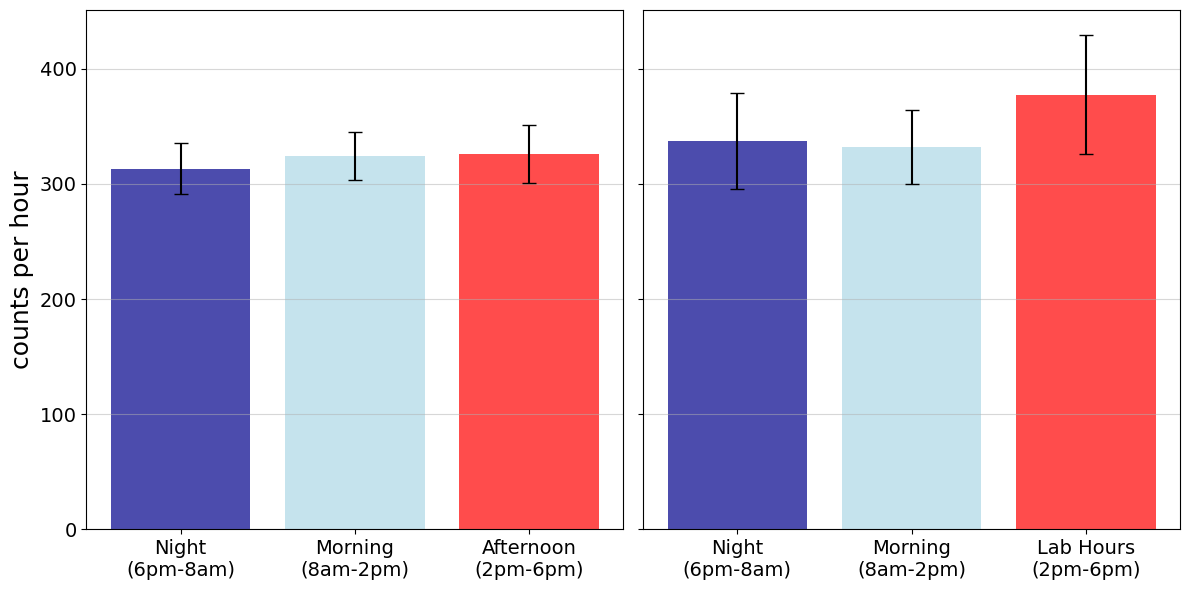

In [112]:
fig, ax = plt.subplots(1, 2, sharey=True)

# FIRST 48 HOURS
y_period = [np.mean(period) for period in [pre_night, pre_morning, pre_afternoon]]
y_period_err = [np.std(period) for period in [pre_night, pre_morning, pre_afternoon]]
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(['Night\n(6pm-8am)', 'Morning\n(8am-2pm)', 'Afternoon\n(2pm-6pm)'])
ax[0].set_ylabel('counts per hour')
ax[0].grid(axis='y', alpha=0.5)
ax[0].bar([1,2,3], y_period, yerr=y_period_err, capsize=5, alpha=0.7,
         color=['darkblue', 'lightblue', 'r'])

# REST OF THE HOURS
y_period = [np.mean(period) for period in [post_night, post_morning, post_lab]]
y_period_err = [np.std(period) for period in [post_night, post_morning, post_lab]]
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(['Night\n(6pm-8am)', 'Morning\n(8am-2pm)', 'Lab Hours\n(2pm-6pm)'])
ax[1].grid(axis='y', alpha=0.5)
ax[1].bar([1,2,3], y_period, yerr=y_period_err, capsize=5, alpha=0.7,
         color=['darkblue', 'lightblue', 'r'])

plt.tight_layout()
plt.savefig('pre_vs_post_run3_hist.jpg', dpi=300, bbox_inches='tight')
plt.show()

Although there is indeed an extra offset for the night and the morning, it is nothing compared to the one in Run 1. And specially nothing compared to the lab hours. This again, supports the theory that activity during the lab affects the counts detected by the scintillator and that during Run 1, that activity might not have been turned off when labs closed between lab days (but during Run 3 they were). The extra offset for the night and the morning that still appears here could be explained due to other activity going on around the builduing but not inside the labs themselves. To see this, we could check if the day of the week (i.e. Saturday/Sunday vs Friday/Monday) affects at all. 

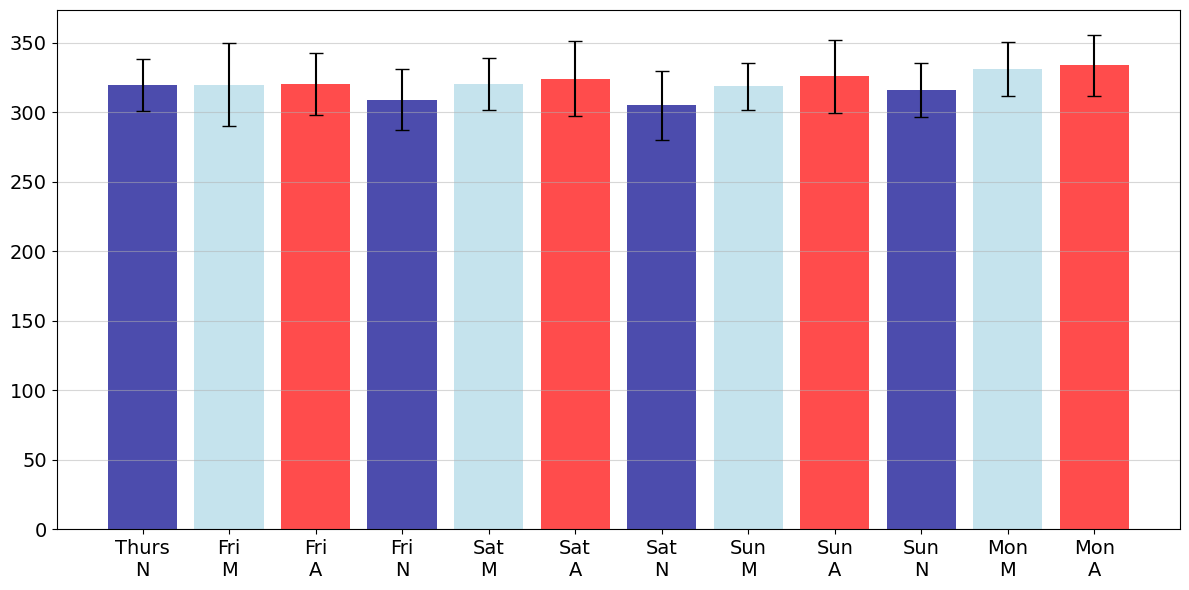

In [32]:
periods2 = [count_rate[0:14], count_rate[14:20], count_rate[20:24],   # thu 6 pm to fri 6 pm
           count_rate[24:38], count_rate[38:44], count_rate[44:48], count_rate[48:62], count_rate[62:68], count_rate[68:72],   # fri 6 pm to sun 6 pm
           count_rate[72:86], count_rate[86:92], count_rate[92:96]]   # sun 6 pm to mon 6 pm

y_period2 = [np.mean(period) for period in periods2]
y_period2_err = [np.std(period) for period in periods2]
xlabels2 = ['Thurs\nN', 'Fri\nM', 'Fri\nA', 
            'Fri\nN', 'Sat\nM', 'Sat\nA', 'Sat\nN', 'Sun\nM', 'Sun\nA',
           'Sun\nN', 'Mon\nM', 'Mon\nA']

plt.xticks(np.arange(12), xlabels2)
plt.grid(axis='y', alpha=0.5)
plt.bar(np.arange(12), y_period2, yerr=y_period2_err, capsize=5, alpha=0.7, color=['darkblue', 'lightblue', 'r', 
                                                                               'darkblue', 'lightblue', 'r', 'darkblue', 'lightblue', 'r', 
                                                                               'darkblue', 'lightblue', 'r'])
plt.tight_layout()
plt.show()

There does seem to be a bit more counts on Thursday night / Monday than over friday, Saturday and Sunday meaning that maybe indeed it is because of lower activity around the builduing on those days that the last 34 hours (includes weekdays) during the nights and mornings also have a certain offset but this is so small it can't be said with certanty that it is that way

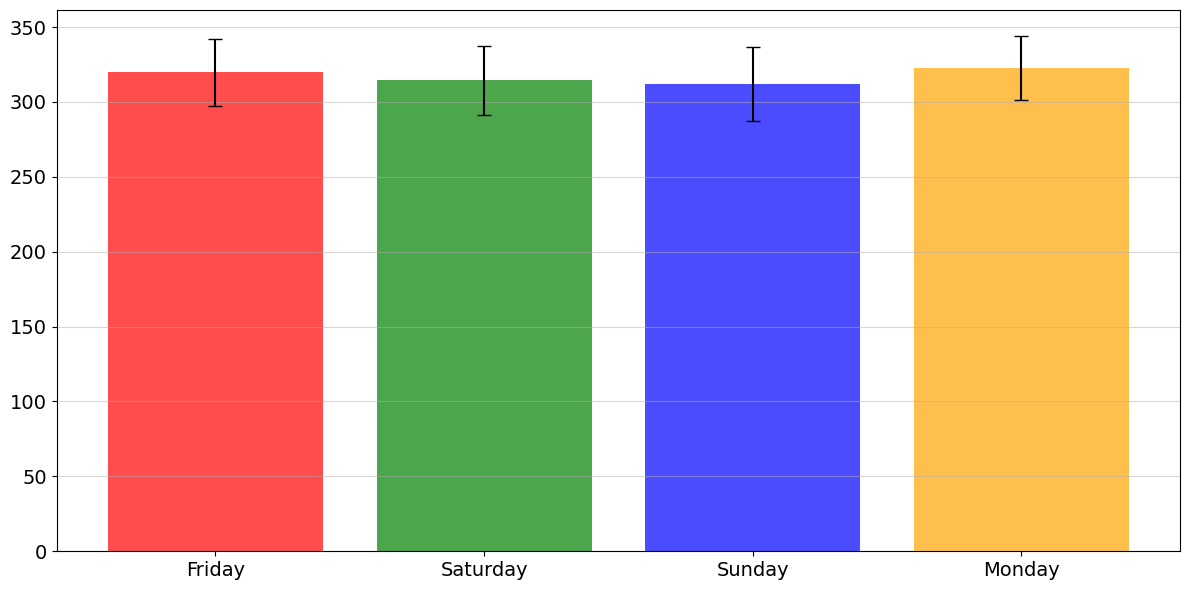

In [33]:
periods2 = [count_rate[0:24], # thu 6 pm to fri 6 pm
           count_rate[24:48], count_rate[48:72],   # fri 6 pm to sun 6 pm
           count_rate[72:96]]   # sun 6 pm to mon 6 pm

y_period2 = [np.mean(period) for period in periods2]
y_period2_err = [np.std(period) for period in periods2]
xlabels2 = ['Friday', 'Saturday', 'Sunday', 'Monday']

plt.xticks(np.arange(4), xlabels2)
plt.grid(axis='y', alpha=0.5)
plt.bar(np.arange(4), y_period2, yerr=y_period2_err, capsize=5, alpha=0.7, color=['r', 'g', 'b', 'orange'])
plt.tight_layout()
plt.show()

Indeed Monday and Friday seem to have a few more counts than Saturday and Sunday

Let's look at how the exponential decay obtained from the first 116 hours (no lab days) looks like

Best-fit line: 41.0123*exp(-t/2.2347) + 0.3464
Uncertainties on: A = 0.3974, tau = 0.0401, C = 0.1433


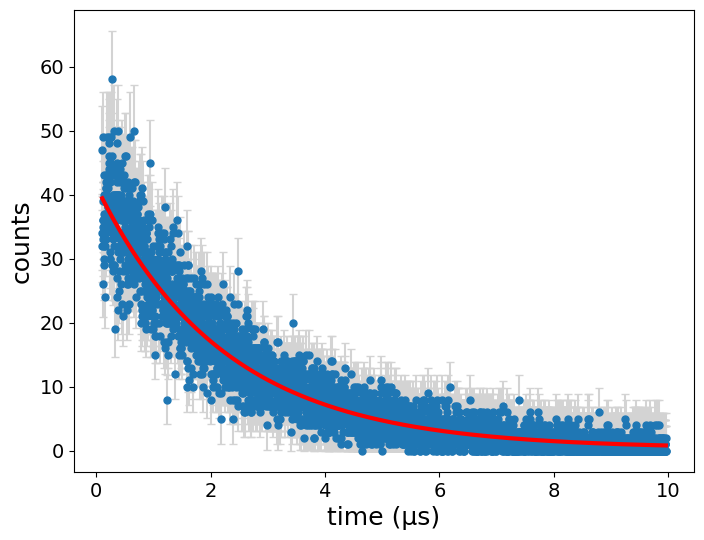

In [113]:
final_data = np.loadtxt('Run3/Run3_116.txt', unpack=True)[44:-109]
yerr = np.sqrt(final_data)   # Poisson noise
# Channels with small or even 0 counts weight the fit wrongfully so set min err
floor = np.median(yerr[:np.argwhere(final_data==0)[0][0]])   # take median of errors of up until where first channel w/ 0 counts is found
yerr[yerr<floor] = floor

x = np.arange(44, len(final_data)+44)
x = (x-c)/m

p0 = [max(final_data), 2.2, min(final_data)]
popt, pcov = curve_fit(decay, x, final_data, sigma=yerr, p0=p0, absolute_sigma=True)
A, tau, C = popt
A_err, tau_err, C_err = np.sqrt(np.diag(pcov))
# Print them for a visual check
print(f"Best-fit line: {A:.4f}*exp(-t/{tau:.4f}) + {C:.4f}")
print(f"Uncertainties on: A = {A_err:.4f}, tau = {tau_err:.4f}, C = {C_err:.4f}")

plt.figure(figsize=(8,6))
lower_err = np.where(final_data - yerr < 0, final_data, yerr)   # make errorbar not go below 0 (unphyisical)
plt.plot(x, decay(x,A,tau,C), 'r-', linewidth=3)
plt.errorbar(x, final_data, yerr=[lower_err,yerr], fmt='o', ms=5, zorder=0, capsize=3, ecolor='lightgray')
plt.xlabel('time (μs)')
plt.ylabel('counts')
plt.savefig('run3_decay.jpg', dpi=300, bbox_inches='tight')
plt.show()

Slighlty better, from 2.377 to 2.347. There is no big difference and definetly not as big as in Run 1 most probably because in Run 1 the full data for the lab days was 'contaminated' meanwhile here it is just a few several occasions making the percentage of 'contaminated' data lower for Run 3 than for Run1